<a href="https://colab.research.google.com/github/zornslemonade/MultiClassNeuralNetwork/blob/main/Basic_MNIST_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classifier

This is a basic feedforward network which classifies MNIST data, implemented from scratch. It utilizes L2 regularization and ADAM optimization.


### Imports

In [ ]:
import numpy as np

### Loading the MNIST data

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


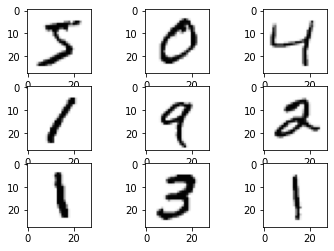

In [ ]:
from keras.datasets import mnist
from matplotlib import pyplot

(train_data, train_labels), (test_data, test_labels) = mnist.load_data()
print('Train: X=%s, y=%s' % (train_data.shape, train_labels.shape))
print('Test: X=%s, y=%s' % (test_data.shape, test_labels.shape))
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(train_data[i], cmap=pyplot.get_cmap('Greys'))
pyplot.show()

In [ ]:
from keras.utils import to_categorical

X_train = train_data[:55000,:,:].reshape((55000,28*28))/255
X_valid = train_data[55000:,:,:].reshape((5000,28*28))/255
X_test = test_data.reshape((10000,28*28))/255

y_train = to_categorical(train_labels[:55000].reshape((55000,1)))
y_valid = to_categorical(train_labels[55000:].reshape((5000,1)))
y_test = to_categorical(test_labels.reshape((10000,1)))

## Neural Network

### Mathematical Functions

In [ ]:
def sigmoid(z):
  a = 1 / (1 + np.exp(-z))
  return a

def sigmoid_prime(x, a):
  return a*(1-a)

def tanh(z):
  return 2*sigmoid(2*z) - 1

def tanh_prime(z, a):
  return (1 + a)*(1 - a)

def softmax(X):
  return np.exp(X)/np.sum(np.exp(X), axis=1, keepdims=True)

def logloss(y_1,y_2):
  return -y_1 * np.log(y_2)

functions = {"sigmoid": sigmoid, "tanh": tanh, "softmax": softmax}
derivatives = {"sigmoid": sigmoid_prime, "tanh": tanh_prime}

### Creating the Network

In [ ]:
class network:
  def __init__(self, layer_dims, hidden_activation_functions = None, learning_rate = .01):
    # To avoid divisions by zero when necessary
    self.epsilon = 10**-8

    self.layer_dims = layer_dims

    # If the hidden layer activation functions are not specified, assume tanh
    # The final layer is always the softmax function
    # The cost function is always m
    if not hidden_activation_functions == None:
      self.activation_functions = hidden_activation_functions
    else:
      self.activation_functions = [None]
      for k in range(1,len(layer_dims)-1):
        self.activation_functions.append("tanh")
    self.activation_functions.append("softmax")

    self.learning_rate = learning_rate

    self.initialize_parameters()
  
  def initialize_parameters(self):

    # Arrays of dictionaries are kept to facilitate the forwards and backwards passes
    # Each includes a dictionary for every layer (including the input layer)
    self.params = [{}]
    self.vs = [{}]
    self.ss = [{}]
    self.grads = [{}]
    self.caches = [{}]

    for l in range(1, len(self.layer_dims)):
      param = {}
      v = {}
      s = {}
      grad = {}
      cache = {}

      # Weights and biases
      # Weights are initialized to have 0 mean and variance 1/n, where n is the
      # size of the previous layer (Xavier initialization)
      param['W'] = 1/self.layer_dims[l-1] * np.random.randn(self.layer_dims[l-1],self.layer_dims[l])
      param['b'] = np.zeros((1,self.layer_dims[l]))

      # Momentum and second moment moving averages
      v['W'] = np.zeros((self.layer_dims[l-1],self.layer_dims[l]))
      s['W'] = np.zeros((self.layer_dims[l-1],self.layer_dims[l]))
      v['b'] = np.zeros((1,self.layer_dims[l]))
      s['b'] = np.zeros((1,self.layer_dims[l]))

      self.params.append(param)
      self.vs.append(v)
      self.ss.append(s)
      self.grads.append(grad)
      self.caches.append(cache)
  
  def current_output(self):
    return self.caches[-1]['A']

  def forward_propagate(self, X):
    # Propagate an input forward through the network

    # All node activations will be stored in a cache for later use
    self.caches[0]['A'] = X

    for l in range(1, len(self.layer_dims)):
      A_prev = self.caches[l-1]['A']
      W = self.params[l]['W']
      b = self.params[l]['b']
      Z = A_prev @ W + b

      # The output layer has a different activation function than the hidden layers
      A = functions[self.activation_functions[l]](Z)

      self.caches[l]['Z'] = Z
      self.caches[l]['A'] = A

  def cost(self, X, Y, A = None):
    # Compute the cost of an input given a target
    if A == None:
      self.forward_propagate(X)
      A = self.current_output()
    cost = np.mean(np.sum(logloss(Y,A), axis=1, keepdims=True))
    return cost
  
  def classify(self, X):
    # Classify an input
    self.forward_propagate(X)
    labels = np.argmax(self.current_output(), axis=1)
    return labels

  def accuracy(self, X, Y, A = None):
    # Compute the accuracy of the classification of an input
    if A == None:
      self.forward_propagate(X)
      A = self.current_output()
    labels = np.argmax(A, axis=1)
    truth = np.argmax(Y, axis=1)
    totals = np.sum(Y, axis=0).astype(int)
    counts = np.zeros(totals.shape).astype(int)
    for k in range(len(truth)):
      if labels[k] == truth[k]:
        counts[labels[k]] += 1
    accuracies = counts/totals

    for k in range(len(totals)):
      print("Category {}:".format(k))
      print("\tClassifed {} of {} samples correctly, for an accuracy of {}%.".format(counts[k],totals[k],round(100*accuracies[k],2)))
      print()
    
    count = np.sum(counts)
    total = np.sum(totals)
    accuracy = count/total
    print("Overall classified {} of {} samples correctly, for an accuracy of {}%.".format(count, total, round(100*accuracy,2)))
    return accuracy

  
  def backward_propagate_step(self, l, Y):
    # Propagate gradients backward through the network, using the current cache
    # This should not be called if forward_propagate has not been called at least once
    Z = self.caches[l]['Z']
    A = self.caches[l]['A']
    # The output layer has a different gradient than the hidden layers
    if l != len(self.layer_dims)-1:
      W_next = self.params[l+1]['W']
      DZ_next = self.grads[l+1]['DZ']
      DZ = (DZ_next @ W_next.transpose()) * derivatives[self.activation_functions[l]](Z,A)
    else:
      DZ = A - Y  ###softmax is hardcoded currently! (need to allow arb activations still!)

    A_prev = self.caches[l-1]['A']
    m = A_prev.shape[1] # Number of samples in the last input (possibly a mini-batch)
      
    DW = 1/m*(A_prev.transpose() @ DZ)
    Db = np.mean(DZ, axis=0, keepdims=True)

    # Store the gradients for future use
    self.grads[l]['DZ'] = DZ
    self.grads[l]['DW'] = DW
    self.grads[l]['Db'] = Db
  
  def update_parameters_step(self, l, n, t, alpha, lambd=0, beta_1=0, beta_2=None):
    # Update the weights and biases using gradient descent
    # Optionally use regularization and moment optimization
    # n: number of samples (not mini-batch size)
    # t: current update count
    # alpha: learning rate
    # lambd: regularization parameter (defaults to no regularization)
    # beta_1: momentum optimization parameter (defaults to no momentum optimization)
    # beta_2: second moment optimization parameter (defaults to no second moment optimization)

    # Calculate momentum (if beta_1 = 0 then this reduces to just the gradient)
    VW = beta_1 * self.vs[l]['W'] + (1 - beta_1) * self.grads[l]['DW']
    Vb = beta_1 * self.vs[l]['b'] + (1 - beta_1) * self.grads[l]['Db']
    self.vs[l]['W'] = VW
    self.vs[l]['b'] = Vb
    if not beta_1 == 1:
      VW = VW / (1 - beta_1**(t+1))
      Vb = Vb / (1 - beta_1**(t+1))

    # The momentum-optimized adjustment
    deltaW = VW
    deltab = Vb

    # Calculate second moment
    if not beta_2 == None:
      SW = beta_2 * self.ss[l]['W'] + (1 - beta_2) * self.grads[l]['DW'] * self.grads[l]['DW']
      Sb = beta_2 * self.ss[l]['b'] + (1 - beta_2) * self.grads[l]['Db'] * self.grads[l]['Db']
      self.ss[l]['W'] = SW
      self.ss[l]['b'] = Sb
      if not beta_2 == 1:
        SW = SW / (1 - beta_2**(t+1))
        Sb = Sb / (1 - beta_2**(t+1))

      # The second-moment-optimized adjustment
      deltaW = deltaW / (np.sqrt(SW) + self.epsilon)
      deltab = deltab / (np.sqrt(Sb) + self.epsilon)
    
    self.params[l]['W'] = (1-alpha*lambd/n)*self.params[l]['W'] - alpha * deltaW
    self.params[l]['b'] = (1-alpha*lambd/n)*self.params[l]['b'] - alpha * deltab
        
  def model(self, X, Y, epochs = 1000, mini_batch_size = None, learning_rate = None, learning_rate_decay = .1, regularization = 0, momentum = 0, second_moment = None, update_every = 100, snapshots_on=[]):
      # Perform gradient descent

      n = X.shape[0] # Number of samples

      label_sets = []
      # A specific learning rate may be provided
      if learning_rate == None: learning_rate = self.learning_rate
      
      t = 0
      for k in range(epochs):
        if k % update_every == 0:
          cost = self.cost(X, Y)   
          print("Cost after {} epochs: {}".format(k, cost))
        if k in snapshots_on:
          label_sets.append(self.classify(X)) 

        if mini_batch_size != None:
          mini_batches = self.random_mini_batches(X, Y, mini_batch_size)
        else:
          mini_batches = (X,Y)
        
        for mini_batch in mini_batches:
          (mini_batch_X, mini_batch_Y) = mini_batch
          self.forward_propagate(mini_batch_X)
          for l in reversed(range(1,len(self.layer_dims))):
            self.backward_propagate_step(l, mini_batch_Y)
            self.update_parameters_step(l, n, t, learning_rate/(1+learning_rate_decay*k), regularization, momentum, second_moment)

        t += 1

      cost = self.cost(X, Y)
      label_sets.append(np.argmax(self.current_output(), axis=0))
      print("Cost after {} epochs: {}".format(k+1, cost))
      return label_sets

  def random_mini_batches(self, X, Y, mini_batch_size):
    # Divide up the input into mini-batches
    # Minibatches can speed up gradient descent
    n = X.shape[0] 
    mini_batches = []
    
    shuffle = list(np.random.permutation(n))
    shuffled_X = X[shuffle, :]
    shuffled_Y = Y[shuffle, :]

    num_complete_minibatches = int(n/mini_batch_size)
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[k*mini_batch_size : (k+1)*mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k*mini_batch_size : (k+1)*mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For when the mini-batch size does not divide the input size
    if n % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size :, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## Testing

In [ ]:
net = network([28*28,30,30,10])

In [ ]:
label_sets = net.model(X_train, y_train, 1000, 128, .01, .1, .1, .9,.999, 100)

Cost after 0 epochs: 2.3025957178417937
Cost after 100 epochs: 0.005419255273184586
Cost after 200 epochs: 0.0003871310640111724
Cost after 300 epochs: 1.6636924897789525e-05
Cost after 400 epochs: 1.3754316049482397e-06
Cost after 500 epochs: 1.1767780809083184e-07
Cost after 600 epochs: 1.2571680662402175e-08
Cost after 700 epochs: 3.537310863538408e-09
Cost after 800 epochs: 1.8017968392798724e-09
Cost after 900 epochs: 1.1967011122780531e-09
Cost after 1000 epochs: 9.051353009136458e-10


In [ ]:
net.accuracy(X_train, y_train)

Category 0:
	Classifed 5434 of 5434 samples correctly, for an accuracy of 100.0%.

Category 1:
	Classifed 6212 of 6212 samples correctly, for an accuracy of 100.0%.

Category 2:
	Classifed 5465 of 5465 samples correctly, for an accuracy of 100.0%.

Category 3:
	Classifed 5622 of 5622 samples correctly, for an accuracy of 100.0%.

Category 4:
	Classifed 5343 of 5343 samples correctly, for an accuracy of 100.0%.

Category 5:
	Classifed 4963 of 4963 samples correctly, for an accuracy of 100.0%.

Category 6:
	Classifed 5436 of 5436 samples correctly, for an accuracy of 100.0%.

Category 7:
	Classifed 5702 of 5702 samples correctly, for an accuracy of 100.0%.

Category 8:
	Classifed 5357 of 5357 samples correctly, for an accuracy of 100.0%.

Category 9:
	Classifed 5466 of 5466 samples correctly, for an accuracy of 100.0%.

Overall classified 55000 of 55000 samples correctly, for an accuracy of 100.0%.


1.0

In [ ]:
net.accuracy(X_test, y_test)

Category 0:
	Classifed 953 of 980 samples correctly, for an accuracy of 97.24%.

Category 1:
	Classifed 1116 of 1135 samples correctly, for an accuracy of 98.33%.

Category 2:
	Classifed 983 of 1032 samples correctly, for an accuracy of 95.25%.

Category 3:
	Classifed 959 of 1010 samples correctly, for an accuracy of 94.95%.

Category 4:
	Classifed 937 of 982 samples correctly, for an accuracy of 95.42%.

Category 5:
	Classifed 838 of 892 samples correctly, for an accuracy of 93.95%.

Category 6:
	Classifed 927 of 958 samples correctly, for an accuracy of 96.76%.

Category 7:
	Classifed 962 of 1028 samples correctly, for an accuracy of 93.58%.

Category 8:
	Classifed 903 of 974 samples correctly, for an accuracy of 92.71%.

Category 9:
	Classifed 954 of 1009 samples correctly, for an accuracy of 94.55%.

Overall classified 9532 of 10000 samples correctly, for an accuracy of 95.32%.


0.9532

I think it's a 5
It's really a 5



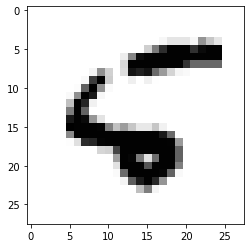

In [ ]:
n = 8
print("I think it's a {}".format(net.classify(X_test)[n]))
print("It's really a {}".format(test_labels[n]))
print()
pyplot.imshow(test_data[n], cmap=pyplot.get_cmap('Greys'))
pyplot.show()
